<a href="https://colab.research.google.com/github/Maryam-71295/CodeAlpha-A-B-Testing-Analysis/blob/main/A_B_Testing_Analysis_CodeAlpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Data Cleaning and Analysis

In [2]:
df = pd.read_csv('/content/AB_Test_Results.csv')

In [3]:
def perform_EDA(dataframe):
    """
    Perform Exploratory Data Analysis (EDA) on the given dataframe.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe to perform EDA on.

    Prints:
        - Dataset Sample: Displays a sample of the dataset.
        - Dataset Information: Provides information about the dataset.
        - Duplicated Values: Calculates and displays the sum of duplicated values in the dataset.
        - Unique Values: Displays the count of unique values in each column of the dataset.
        - Dataset Description: Provides descriptive statistics of the dataset.

    Returns:
        None
    """
    print("---- Dataset Sample ".ljust(50, '-'))
    print('')
    print(dataframe.sample(n = 10))
    print('')
    print("---- Dataset Information ".ljust(50, '-'))
    print('')
    print(dataframe.info())
    print('')
    print("---- Duplicated Values ".ljust(50, '-'))
    print('')
    print('Sum of Duplicated Values:', df.duplicated().sum())
    print('')
    print('')
    print("---- Unique Values ".ljust(50, '-'))
    print('')
    print(df.nunique())
    print('')
    print("---- Dataset Description ".ljust(50, '-'))
    print('')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print('')

perform_EDA(df)

---- Dataset Sample ------------------------------

      USER_ID VARIANT_NAME  REVENUE
1064     9998      control  0.00000
8756      570      variant  0.00000
6865     6333      control  0.00000
252      2187      control  0.00000
1984     2792      variant  0.00000
3007     4663      variant  0.00000
6392     1985      control  0.00000
9472     1794      variant  0.00000
6365     2284      variant  0.00000
8916     2424      variant  0.00000

---- Dataset Information -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None

---- Duplicated Values ---------------------------

Sum of Duplicated Values: 2067


---- Unique Values ---

In [4]:
variant_group = df[df['VARIANT_NAME'] == 'variant'].drop_duplicates(keep = 'first')
control_group = df[df['VARIANT_NAME'] == 'control'].drop_duplicates(keep = 'first')
df = pd.concat([variant_group, control_group], ignore_index = True)
df.reset_index(drop=True, inplace=True)

In [5]:
conf_int = sms.DescrStatsW(df['REVENUE']).tconfint_mean()

print(f'95% confidence interval for Revenue: {conf_int}')

95% confidence interval for Revenue: (0.06808022416158013, 0.18263703286602603)


In [6]:
def outlier_thresholds(dataframe, variable):
    """
    Calculate the lower and upper outlier thresholds for a given variable in the dataframe.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe containing the variable.
        variable (str): The name of the variable for which outlier thresholds will be calculated.

    Returns:
        tuple: A tuple containing the lower and upper outlier thresholds.
    """
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()


def replace_with_thresholds(dataframe, variable):
    """
    Replace the outliers in the given variable of the dataframe with the lower and upper thresholds.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe containing the variable.
        variable (str): The name of the variable for which outliers will be replaced.

    Returns:
        None
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "REVENUE")

In [7]:
conf_int = sms.DescrStatsW(df['REVENUE']).tconfint_mean()

print(f'95% confidence interval for Revenue: {conf_int}')

95% confidence interval for Revenue: (0.04618289998844694, 0.06783701681478009)


Hypothesis Overview

In [8]:
df.groupby('VARIANT_NAME').agg({'REVENUE': 'mean'})

,REVENUE
VARIANT_NAME,
control,0.06509
variant,0.04890


Conducting Hypothesis Testing

In [9]:
test_stat, pvalue = shapiro(df.loc[df["VARIANT_NAME"] == "variant", "REVENUE"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

test_stat, pvalue = shapiro(df.loc[df["VARIANT_NAME"] == "control", "REVENUE"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0877, p-value = 0.0000
Test Stat = 0.0992, p-value = 0.0000


In [10]:
test_stat, pvalue = mannwhitneyu(df.loc[df["VARIANT_NAME"] == "variant", "REVENUE"],
                                 df.loc[df["VARIANT_NAME"] == "control", "REVENUE"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 7850692.0000, p-value = 0.5129


Case Study 2

Data Cleaning Analysis

In [11]:
df = pd.read_csv('/content/ab_data.csv')
perform_EDA(df)

---- Dataset Sample ------------------------------

        user_id                   timestamp      group landing_page  converted
246450   838288  2017-01-14 07:17:35.278411    control     old_page          0
21837    875927  2017-01-14 11:15:35.980024    control     old_page          0
262132   945930  2017-01-15 13:42:27.867629    control     old_page          0
145350   932509  2017-01-13 19:18:27.822269    control     old_page          0
30976    834873  2017-01-08 16:52:33.231211  treatment     new_page          0
184241   694555  2017-01-22 18:23:30.587049    control     old_page          0
50543    640489  2017-01-21 17:28:56.290311  treatment     new_page          1
88834    763055  2017-01-21 04:35:21.654045  treatment     new_page          0
149063   699674  2017-01-24 00:38:12.319991  treatment     new_page          0
207908   837443  2017-01-20 05:10:01.162743    control     old_page          0

---- Dataset Information -------------------------

<class 'pandas.core.frame.

In [12]:
df.drop_duplicates( subset = 'user_id', keep = 'first', inplace = True)

df.nunique()

,0
user_id,290584
timestamp,290584
group,2
landing_page,2
converted,2


In [13]:
confidence_level = 0.95 # --> The confidence level specified when formulating the hypothesis.
alpha = 1 - confidence_level # --> The significance level or alpha value, representing the maximum risk level for the hypothesis.
power = 0.8 # --> The measure of the probability of not rejecting the null hypothesis when it is false, often set to 0.8 for medical research.
effect_size = 0.02 # --> A small effect size that is considered acceptable for our analysis, set to 0.02.
random_state = 42 # --> A reference to Douglas Adams' number 42, related to the meaning of the universe.

n = sms.NormalIndPower().solve_power(
                                     effect_size = effect_size,
                                     alpha = alpha,
                                     power = power,
                                     ratio = 1
                                    )

sample_control = df.loc[df['group'] == 'control'].sample(n = round(n), random_state = random_state)
sample_treatment = df.loc[df['group'] == 'treatment'].sample(n = round(n), random_state = random_state)

ab_test = pd.concat([sample_control, sample_treatment], axis = 0).reset_index(drop = True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,723859,2017-01-13 13:23:44.371785,control,old_page,1
1,729591,2017-01-03 10:26:48.735727,control,old_page,0
2,791807,2017-01-13 16:59:18.346932,control,old_page,0
3,695740,2017-01-11 16:04:38.540309,control,old_page,0
4,712633,2017-01-13 12:26:18.400155,control,old_page,0
...,...,...,...,...,...
78483,727409,2017-01-17 01:59:05.840135,treatment,new_page,0
78484,918113,2017-01-11 17:43:59.709647,treatment,new_page,0
78485,813699,2017-01-20 07:42:19.393500,treatment,new_page,0
78486,728202,2017-01-04 13:42:23.249874,treatment,new_page,0


In [14]:
perform_EDA(ab_test)

---- Dataset Sample ------------------------------

       user_id                   timestamp      group landing_page  converted
48913   769755  2017-01-23 16:35:00.565643  treatment     new_page          1
53348   865211  2017-01-03 23:57:32.518768  treatment     new_page          0
28458   834127  2017-01-23 23:16:53.900130    control     old_page          0
13011   749808  2017-01-19 21:23:47.478107    control     old_page          0
67675   751212  2017-01-15 10:54:40.497481  treatment     new_page          0
27282   644398  2017-01-22 11:40:25.191470    control     old_page          0
44230   661084  2017-01-08 19:50:34.054410  treatment     new_page          0
6831    773725  2017-01-05 12:31:33.520681    control     old_page          0
49390   632910  2017-01-15 21:58:32.154322  treatment     new_page          0
71727   938919  2017-01-13 14:47:41.733658  treatment     new_page          0

---- Dataset Information -------------------------

<class 'pandas.core.frame.DataFrame'>

Define Hypothesis

In [15]:
conversion_rates = ab_test.groupby('group')['converted'].agg(['mean','std','sem'])
conversion_rates.columns = ['conversion_rate', 'std_deviation','std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.002
treatment,0.118,0.323,0.002


In [16]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = [go.Bar(x=conversion_rates.index, y=conversion_rates['conversion_rate'],
              error_y=dict(type='data', array=conversion_rates['std_error'],visible=True), marker_color = ['#7149C6', '#FC2947'])]

layout = go.Layout(title='Conversion rate by group', xaxis=dict(title='Group'),yaxis=dict(title='Converted (proportion)',
                                                                                        range=[0, 0.17]))

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)

Conducting Hypothesis Test

In [17]:
c_results = ab_test.loc[ab_test['group'] == 'control', 'converted']
t_results = ab_test.loc[ab_test['group'] == 'treatment', 'converted']


test_stat, pvalue = proportions_ztest([c_results.sum(), t_results.sum()],
                                nobs = [len(c_results), len(t_results)])

conf_int_c = sms.DescrStatsW(c_results).tconfint_mean()
conf_int_t = sms.DescrStatsW(t_results).tconfint_mean()

print(f'Test Stat: {test_stat:.4f}')
print(f'p-value: {pvalue:.4f}')
print(f'95% confidence interval for control group: {conf_int_c}')
print(f'95% confidence interval for treatment group: {conf_int_t}')

Test Stat: 0.9259
p-value: 0.3545
95% confidence interval for control group: (0.11687846293145158, 0.12331112018953506)
95% confidence interval for treatment group: (0.114762924942806, 0.12114574899461118)


# **A/B Testing Analysis for an ad-tech company**

In [18]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Install pingouin library
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.4 MB/s eta 0:00:00


In [20]:
import pingouin

In [31]:
# Read the CSV file with a semicolon delimiter
file_path1 = '/content/test_group.csv'
test = pd.read_csv(file_path1, delimiter=';', header=0)
# Convert each csv to dataframe
file_path2 = ('/content/control_group.csv')
control = pd.read_csv(file_path2, delimiter=';', header=0)

Data Preprocessing

In [32]:
# Show first rows of test dataframe
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [33]:
# Show first rows of control dataframe
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.00000,56930.00000,7016.00000,2290.00000,2159.00000,1819.00000,618.00000
1,Control Campaign,2.08.2019,1757,121040.00000,102513.00000,8110.00000,2033.00000,1841.00000,1219.00000,511.00000
2,Control Campaign,3.08.2019,2343,131711.00000,110862.00000,6508.00000,1737.00000,1549.00000,1134.00000,372.00000
3,Control Campaign,4.08.2019,1940,72878.00000,61235.00000,3065.00000,1042.00000,982.00000,1183.00000,340.00000
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Concatenate the tables in a new dataframe
df = pd.concat([test, control], axis = 0)

# Reset the index
df = df.reset_index(drop = True)

In [35]:
# Show first rows of the data
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.00000,35820.00000,3038.00000,1946.00000,1069.00000,894.00000,255.00000
1,Test Campaign,2.08.2019,2542,100719.00000,91236.00000,4657.00000,2359.00000,1548.00000,879.00000,677.00000
2,Test Campaign,3.08.2019,2365,70263.00000,45198.00000,7885.00000,2572.00000,2367.00000,1268.00000,578.00000
3,Test Campaign,4.08.2019,2710,78451.00000,25937.00000,4216.00000,2216.00000,1437.00000,566.00000,340.00000
4,Test Campaign,5.08.2019,2297,114295.00000,95138.00000,5863.00000,2106.00000,858.00000,956.00000,768.00000


In [36]:
# Obtain information from the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.8+ KB


In [37]:
# Change 'Date' data type to date
df['Date'] = pd.to_datetime(df["Date"], dayfirst = True).dt.date

# Change 'Spend [USD]' from integer to float
df['Spend [USD]'] = df['Spend [USD]'].astype(float)

In [38]:
# Obtain summary statistics of the data
df.describe()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
count,60.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000
mean,2425.75000,91775.88136,70868.64407,5682.59322,2321.81356,1900.16949,1087.22034,522.00000
std,381.13046,32465.07064,31023.65352,1754.77756,669.04058,687.26384,430.20525,196.97392
min,1757.00000,22521.00000,10598.00000,2277.00000,1001.00000,848.00000,278.00000,222.00000
25%,2073.75000,68853.50000,43230.00000,4227.50000,1962.50000,1249.00000,848.50000,340.00000
50%,2420.50000,95843.00000,76219.00000,5691.00000,2390.00000,1975.00000,1075.00000,501.00000
75%,2727.50000,117315.00000,95490.50000,7218.50000,2778.50000,2424.00000,1386.50000,693.00000
max,3112.00000,145248.00000,127852.00000,8264.00000,4891.00000,4219.00000,1913.00000,890.00000


In [39]:
# Count the values in each categorical column
df['Campaign Name'].value_counts()

,count
Campaign Name,
Test Campaign,30
Control Campaign,30


<Axes: xlabel='Spend [USD]', ylabel='Density'>

<Axes: xlabel='# of Impressions', ylabel='Density'>

<Axes: xlabel='# of Website Clicks', ylabel='Density'>

<Axes: xlabel='# of Purchase', ylabel='Density'>

Text(0.5, 0, 'Spend (USD)')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'KDE - Spend (USD)')

Text(0.5, 0, 'Impressions')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'KDE - Number of Impressions')

Text(0.5, 0, 'Website Clicks')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'KDE - Number of Website Clicks')

Text(0.5, 0, 'Purchase')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'KDE - Number of Purchase')

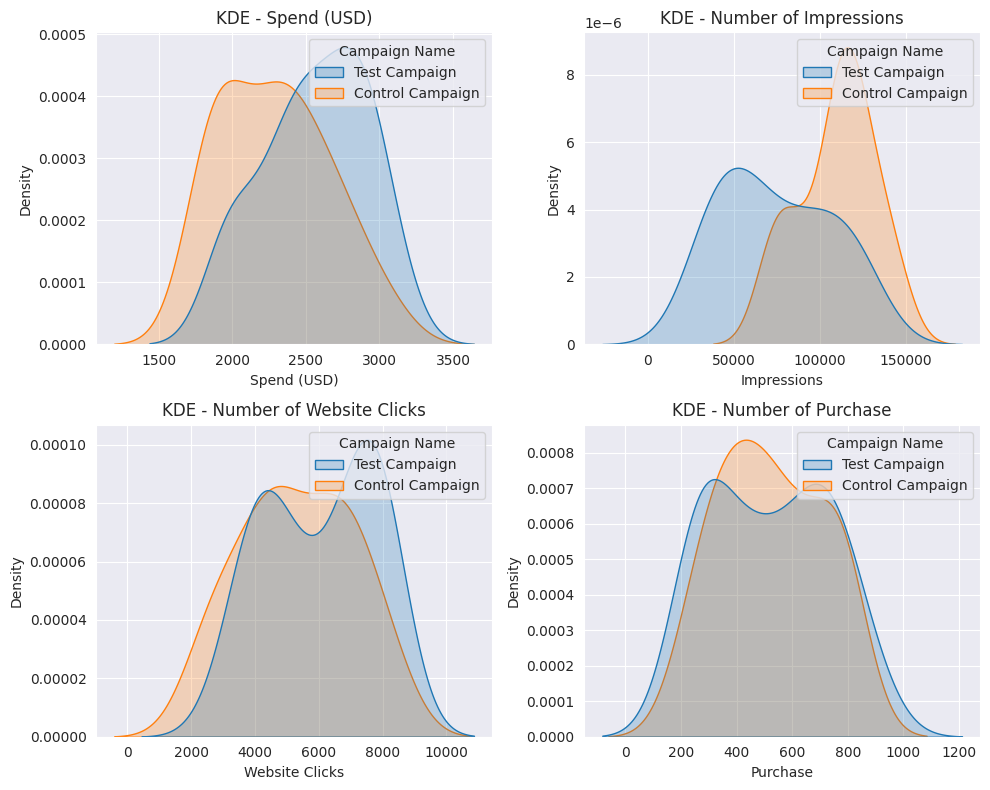

In [40]:
# Set an style for the plots
sns.set_style('darkgrid')

# Create a fig and axis for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Create a kde plot for each numerical variable
sns.kdeplot(data=df, x = 'Spend [USD]', ax=axes[0, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Impressions', ax=axes[0, 1], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Website Clicks', ax=axes[1, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Purchase', ax=axes[1, 1], hue = 'Campaign Name', fill = True)

# Add labels and titles to each plot
axes[0, 0].set_xlabel("Spend (USD)")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("KDE - Spend (USD)")

axes[0, 1].set_xlabel("Impressions")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("KDE - Number of Impressions")

axes[1, 0].set_xlabel("Website Clicks")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("KDE - Number of Website Clicks")

axes[1, 1].set_xlabel("Purchase")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("KDE - Number of Purchase")

plt.tight_layout()

Data Cleaning

In [41]:
# Obtain number of missing values by column
df.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [42]:
# Subset the dataframe to show rows with missing data
df[df.isnull().any(axis=1)]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
34,Control Campaign,2019-08-05,1835.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Create a dictionary containing the mean of each group for all the variables with missing values
var_dict = df.groupby('Campaign Name')[['# of Impressions', '# of Website Clicks', '# of Purchase']].mean().round(0).to_dict()

# Impute the mean by subgroup, depending on campaign name, using the dictionary
for column, group_means in var_dict.items():
    df[column] = df[column].fillna(df['Campaign Name'].map(group_means))

In [45]:
# Check null values again
df.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,0
Reach,1
# of Website Clicks,0
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,0


<Figure size 1200x2400 with 0 Axes>

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, 'Spend [USD] box plot')

([<matplotlib.axis.XTick at 0x7f837cfb2c50>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of Impressions box plot')

([<matplotlib.axis.XTick at 0x7f837be26590>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, 'Reach box plot')

([<matplotlib.axis.XTick at 0x7f837a99e290>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of Website Clicks box plot')

([<matplotlib.axis.XTick at 0x7f837692dd80>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of Searches box plot')

([<matplotlib.axis.XTick at 0x7f837688e2c0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of View Content box plot')

([<matplotlib.axis.XTick at 0x7f837682de10>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of Add to Cart box plot')

([<matplotlib.axis.XTick at 0x7f837a9dde40>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.03, '# of Purchase box plot')

([<matplotlib.axis.XTick at 0x7f83768b5ab0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

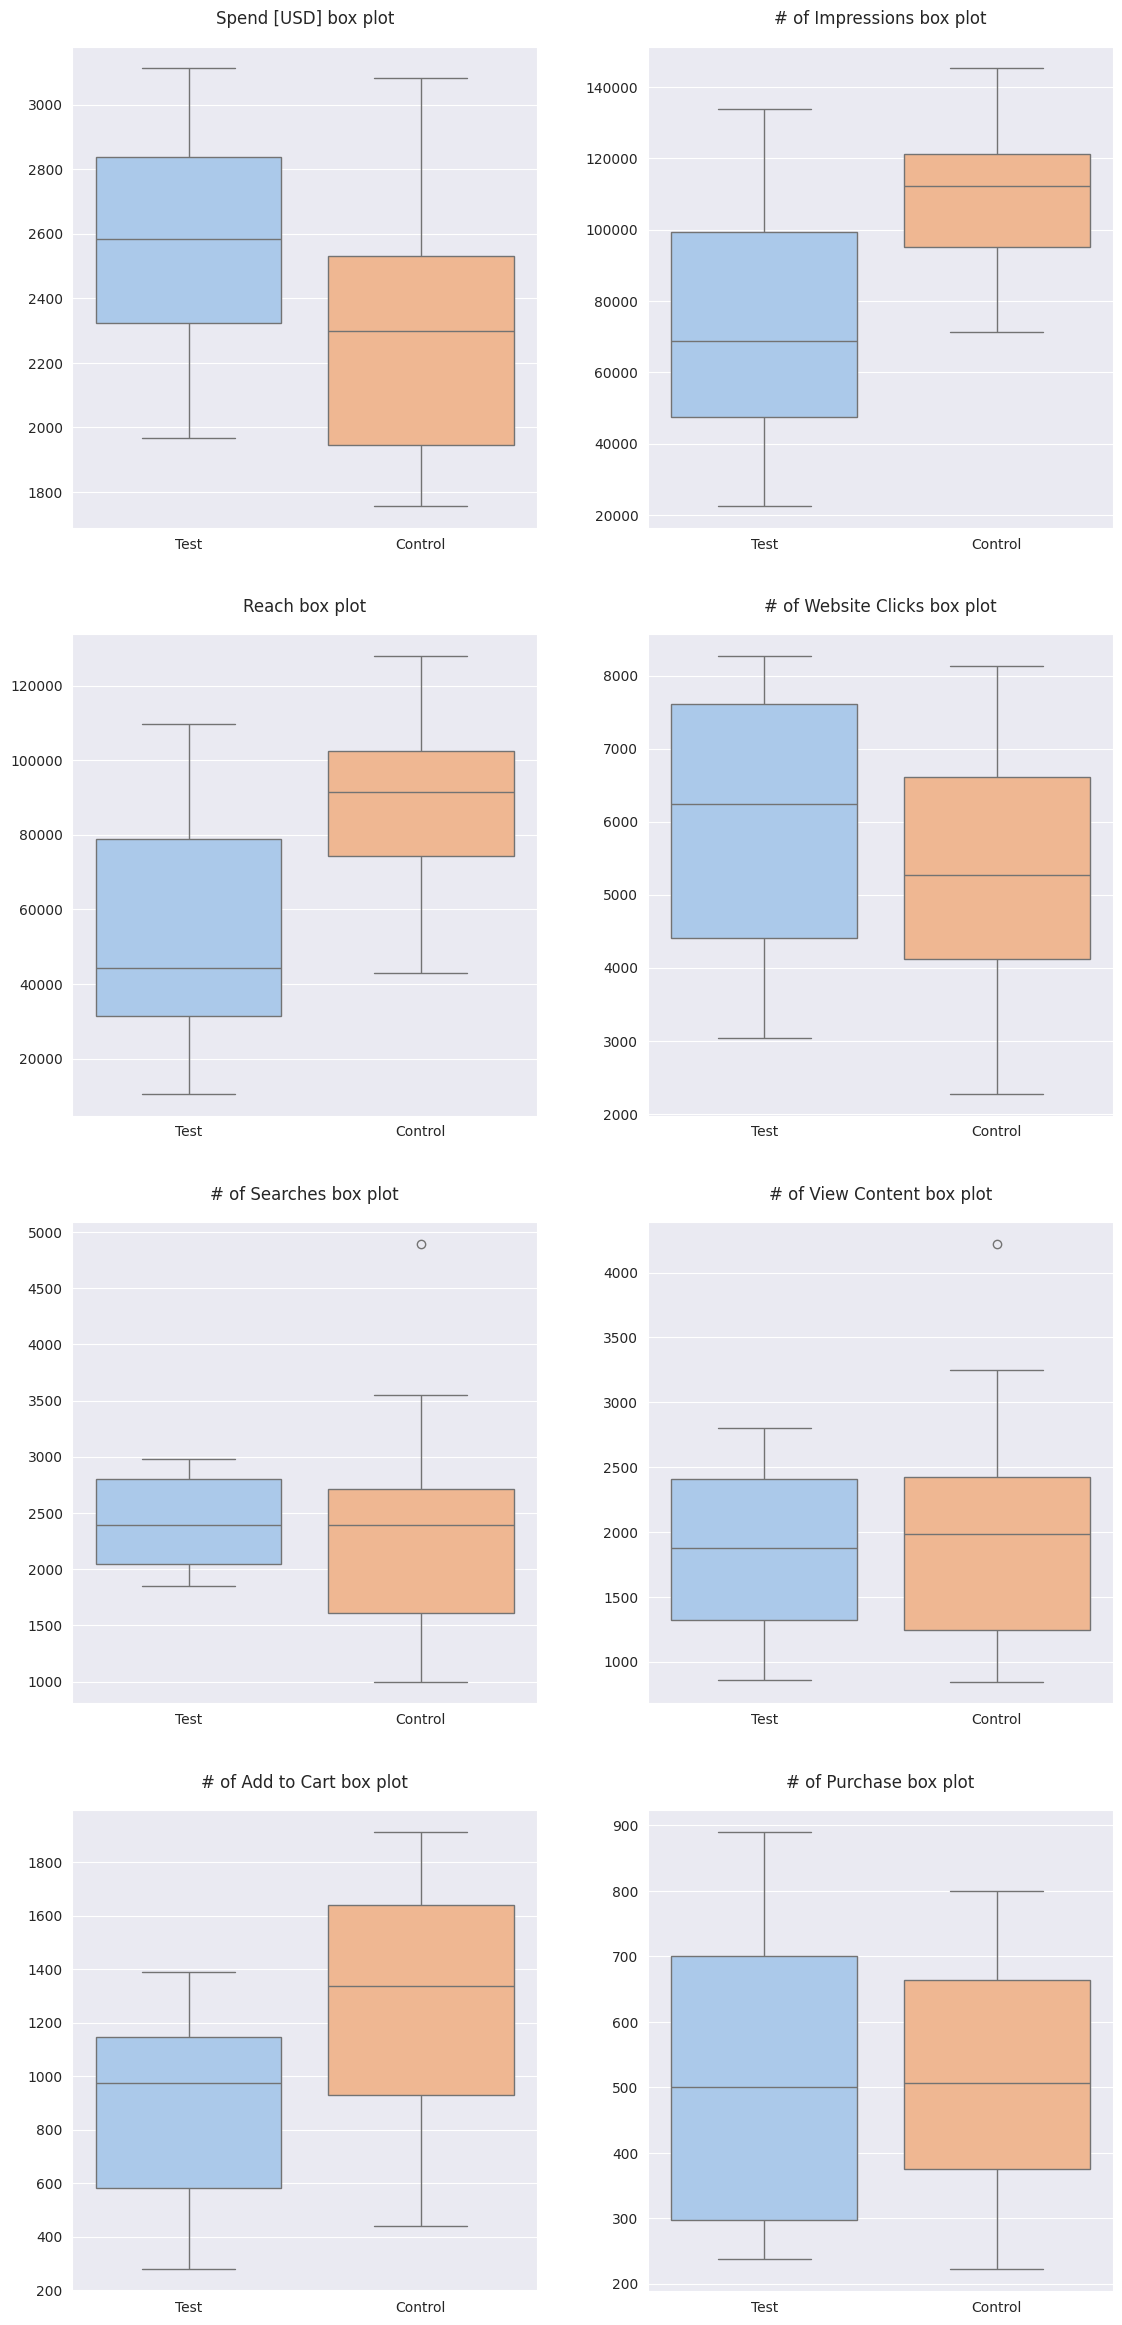

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Numerical columns from df to examine
num_vars = list(df.select_dtypes(include=np.number).columns)

# Determine the number of rows and columns for subplots
n_vars = len(num_vars)
n_rows = int(np.ceil(n_vars / 2))  # Two columns per row

plt.figure(figsize=(12, 6 * n_rows))

for n, var in enumerate(num_vars, start=1):
    # Select the subplot
    plt.subplot(n_rows, 2, n)

    # Create the box plot
    g = sns.boxplot(data=df, y=var, x='Campaign Name', palette='pastel')

    # Customize titles and labels
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{var} box plot', y=1.03)
    plt.xticks(ticks=[0, 1], labels=['Test', 'Control'])  # Ensure labels match data

# Adjust layout
plt.tight_layout(pad=3.5)
plt.show()

Metrics Creations

In [48]:
# Create a new colum and perform calculations for each metric
df['CTR'] = df['# of Website Clicks'] / df['# of Impressions']
df['CR'] = df['# of Purchase'] / df['# of Website Clicks']
df['CPC'] = df['Spend [USD]'] / df['# of Website Clicks']
df['CPA'] = df['Spend [USD]'] / df['# of Purchase']


# Show results
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,CTR,CR,CPC,CPA
0,Test Campaign,2019-08-01,3008.00000,39550.00000,35820.00000,3038.00000,1946.00000,1069.00000,894.00000,255.00000,0.07681,0.08394,0.99013,11.79608
1,Test Campaign,2019-08-02,2542.00000,100719.00000,91236.00000,4657.00000,2359.00000,1548.00000,879.00000,677.00000,0.04624,0.14537,0.54584,3.75480
2,Test Campaign,2019-08-03,2365.00000,70263.00000,45198.00000,7885.00000,2572.00000,2367.00000,1268.00000,578.00000,0.11222,0.07330,0.29994,4.09170
3,Test Campaign,2019-08-04,2710.00000,78451.00000,25937.00000,4216.00000,2216.00000,1437.00000,566.00000,340.00000,0.05374,0.08065,0.64279,7.97059
4,Test Campaign,2019-08-05,2297.00000,114295.00000,95138.00000,5863.00000,2106.00000,858.00000,956.00000,768.00000,0.05130,0.13099,0.39178,2.99089


Analysing of Results

<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, '# of Impressions Bar plot')

([<matplotlib.axis.XTick at 0x7f837c098fd0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '2.23754e+06')]

[Text(0, 0, '3.28679e+06')]

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, '# of Website Clicks Bar plot')

([<matplotlib.axis.XTick at 0x7f837c0fb7c0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '180970')]

[Text(0, 0, '159624')]

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, '# of Purchase Bar plot')

([<matplotlib.axis.XTick at 0x7f837c82a6e0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '15637')]

[Text(0, 0, '15684')]

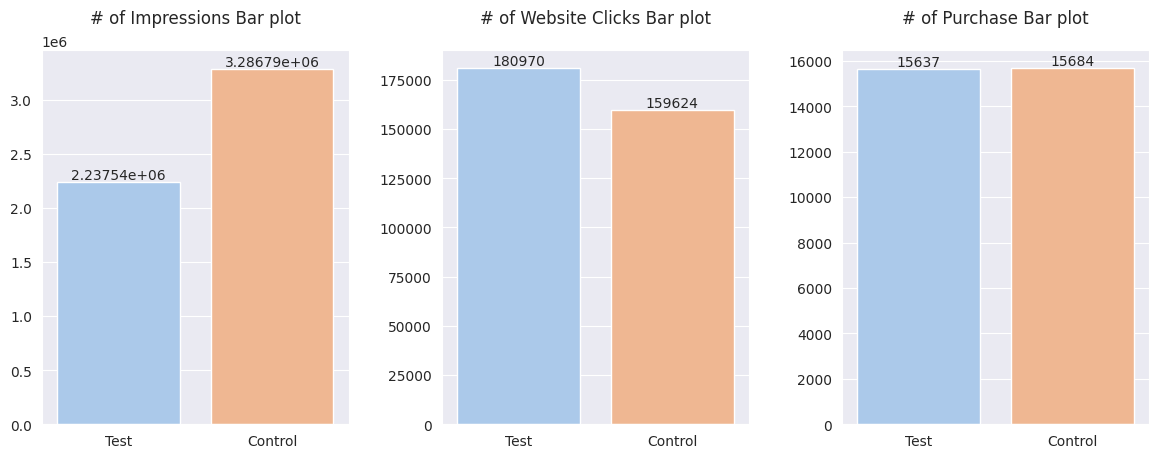

In [49]:
# Create a bar chart for totals
# Numerical columns from df I want to examine
num_vars = ['# of Impressions', '# of Website Clicks', '# of Purchase']

# Create a bar plot for all variables in num_vars
n = 1

plt.figure(figsize= (12, 5))

for var in num_vars:
    # Select the subplot
    plt.subplot(1, 3, n)

    # Create the plot
    g = sns.barplot(data=df, y=var, x= 'Campaign Name', palette = 'pastel', estimator = 'sum', errorbar=('ci', False))

    # Change labels and titles
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{var} Bar plot', y =1.05)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    for i in g.containers:
        g.bar_label(i,)

    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

<Figure size 1600x500 with 0 Axes>

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, 'CTR')

([<matplotlib.axis.XTick at 0x7f837c0ecca0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '0.102423')]

[Text(0, 0, '0.050879')]

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, 'CR')

([<matplotlib.axis.XTick at 0x7f837435f550>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '0.0923118')]

[Text(0, 0, '0.114223')]

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, 'CPC')

([<matplotlib.axis.XTick at 0x7f83741a64d0>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '0.468718')]

[Text(0, 0, '0.489906')]

<Axes: >

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.05, 'CPA')

([<matplotlib.axis.XTick at 0x7f8374215030>,
 [Text(0, 0, 'Test'), Text(1, 0, 'Control')])

[Text(0, 0, '5.89959')]

[Text(0, 0, '5.00088')]

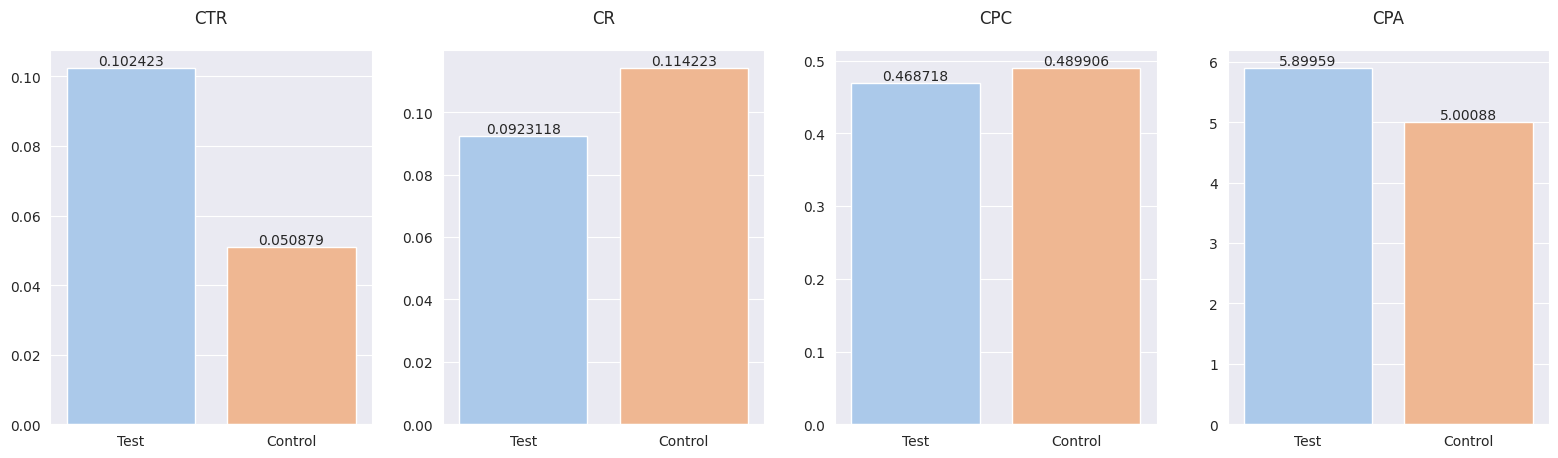

In [50]:
# Create a bar chart for each metric
# Create a list of the columns containing the metrics
metrics = ['CTR', 'CR', 'CPC', 'CPA']

# Create a bar plot for each column in metrics
n = 1

plt.figure(figsize= (16, 5))

for m in metrics:
    # Select the subplot
    plt.subplot(1, 4, n)

    # Create the plot
    g = sns.barplot(data=df, y=m, x= 'Campaign Name', palette = 'pastel', estimator = 'mean', errorbar=('ci', False))

    # Change labels and titles
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{m}', y =1.05)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    for i in g.containers:
        g.bar_label(i,)

    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

Normality Test

<Figure size 1600x500 with 0 Axes>

<Axes: >

Text(0.5, 1.03, 'CTR')

<Axes: >

Text(0.5, 1.03, 'CR')

<Axes: >

Text(0.5, 1.03, 'CPC')

<Axes: >

Text(0.5, 1.03, 'CPA')

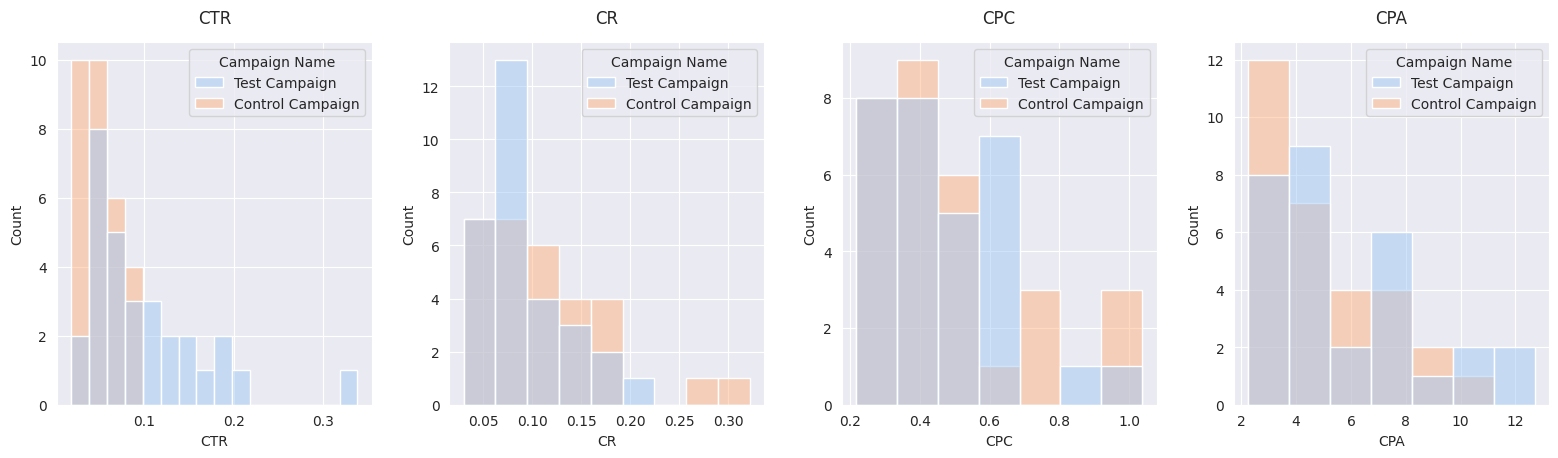

In [51]:
metrics = ['CTR', 'CR', 'CPC', 'CPA']

# Create a histogram for each column in metrics
n = 1

plt.figure(figsize= (16, 5))

for m in metrics:
    # Select the subplot
    plt.subplot(1, 4, n)

    # Create the plot
    g = sns.histplot(data=df, x=m,  palette = 'pastel', hue = 'Campaign Name')

    # Add a title
    g.set_title(f'{m}', y =1.03)

    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

In [52]:
metrics = ['CTR', 'CR', 'CPC', 'CPA']

for m in metrics:

    # Use shapiro() function from scipy for the m metric
    result = shapiro(df[m])
    statistic = result[0]
    p_value = result[1]

    # Show the result
    print(f'{m} Shapiro-Wilk Test:\n')
    print(f'\t- Statistic: {statistic}')
    print(f'\t- P-value: {p_value}\n\n')

CTR Shapiro-Wilk Test:

	- Statistic: 0.7670427656810248
	- P-value: 2.224475199384245e-08


CR Shapiro-Wilk Test:

	- Statistic: 0.8906092553526206
	- P-value: 6.085461021791016e-05


CPC Shapiro-Wilk Test:

	- Statistic: 0.8914336403672993
	- P-value: 6.50281014290301e-05


CPA Shapiro-Wilk Test:

	- Statistic: 0.8985585662086654
	- P-value: 0.00011659905008285464




Mann Whitney U Test

In [53]:
# Create a function to perform Mann Whitney U Test on all metrics
def mann_whitney_u(metric, alpha):

    # Convert table to wide format using pivot
    df_wide = df.pivot(columns = 'Campaign Name', values = metric)

    # Use mwu from pingouin to perform the test
    test = pingouin.mwu(
                 x = df_wide['Control Campaign'],
                 y = df_wide['Test Campaign'],
                 alternative = 'two-sided'
                )

    # Save U-value and p-value from the test
    u_value = test.loc['MWU','U-val']
    p_value = test.loc['MWU', 'p-val'].round(5)

    # Print a result based on level of significance (alpha)
    print('\nMann Whitney U test for {}:\n'.format(metric))
    print(f'\t- p value is {p_value}\n')
    print(f'\t- U value is {u_value}\n')

    if p_value < alpha:
        print('\nWe reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test {}.'.format(metric))

    else:
        print('\nWe fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test {}.'.format(metric))

CTR - Click-Through Rate

In [54]:
# Performn MWU test for CTR metric
mann_whitney_u(metric = 'CTR', alpha = 0.05)


Mann Whitney U test for CTR:

	- p value is 0.00021

	- U value is 199.0


We reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test CTR.


CR - Conversion Rate

In [55]:
# Performn MWU test for CR metric
mann_whitney_u(metric = 'CR', alpha = 0.05)


Mann Whitney U test for CR:

	- p value is 0.28378

	- U value is 523.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CR.


CPC - Cost Per Click

In [56]:
# Performn MWU test for CPC metric
mann_whitney_u(metric = 'CPC', alpha = 0.05)


Mann Whitney U test for CPC:

	- p value is 0.87663

	- U value is 461.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPC.


CPA - Cost Per Acquisition

In [57]:
# Performn MWU test for CPA metric
mann_whitney_u(metric = 'CPA', alpha = 0.05)


Mann Whitney U test for CPA:

	- p value is 0.22823

	- U value is 368.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPA.


Test Conclusion

The decrease in various options through conversion rate (CR), CPC and CPA has no significant difference between the groups and therefore, this study did not take any conclusions based on these results regarding the better bidding model.
However, comparing the two campaigns using Mann-Whitney U test, there is enough evidence to support that the two are significantly different based on the CTR (Click-Through Rate); a mean by which the effectiveness of the ads placed is analysed in terms of the likely hood of users clicking the ad. In such regard, it can be stated that according to the results of the developed analysis, it can be observed that the CTR, on average, is significantly higher for the experimental group as compared to the control one when it is assessed on the base of the bar charts. This can be regarded as a statistically significant increase of CTR in the experimental group compared with the control one.
Still, it should be noted that significant difference is quite often different from difference with practical relevance. Although in quantitative measurement the calculated difference is often statistically significant, it is equally important to evaluate whether these differences are from a practical standpoint and if they are important to the business mission. The difference between the averages of the two groups in terms of this measure is about 0.5%, (0.102423 test campaign – 0.050879 control campaign). Whether this change affects the business significantly, it becomes possible to make the experimental campaign (Average Bidding) permanent.